 Installation et Configuration

In [ ]:
# Installer des bibliothèques nécessaires (si ce n'est pas fait)
!pip install pandas scikit-learn matplotlib seaborn

Chargement de la Base de Données

In [ ]:
import pandas as pd

# Charger le fichier CSV
from google.colab import files
uploaded = files.upload()  # Télécharger votre fichier disney_movies.csv

# Lire le fichier
data = pd.read_csv("/content/disney_movies.csv")

# Aperçu des données
print("Aperçu des données :")
print(data.head())

# Vérifier les colonnes
print("\nColonnes disponibles :", data.columns)


Saving disney_movies.csv to disney_movies (1).csv
Aperçu des données :
                       movie_title release_date      genre mpaa_rating  \
0  Snow White and the Seven Dwarfs   1937-12-21    Musical           G   
1                        Pinocchio   1940-02-09  Adventure           G   
2                         Fantasia   1940-11-13    Musical           G   
3                Song of the South   1946-11-12  Adventure           G   
4                       Cinderella   1950-02-15      Drama           G   

   total_gross  inflation_adjusted_gross  
0    184925485                5228953251  
1     84300000                2188229052  
2     83320000                2187090808  
3     65000000                1078510579  
4     85000000                 920608730  

Colonnes disponibles : Index(['movie_title', 'release_date', 'genre', 'mpaa_rating', 'total_gross',
       'inflation_adjusted_gross'],
      dtype='object')


Nettoyage et Préparatio des Données


In [ ]:
# Vérifier les valeurs manquantes
print("\nValeurs manquantes :")
print(data.isnull().sum())

# Nettoyer les données (supprimer les lignes avec valeurs manquantes)
data_cleaned = data.dropna()

# Vérifier les types des données
print("\nTypes des colonnes après nettoyage :")
print(data_cleaned.info())



Valeurs manquantes :
movie_title                  0
release_date                 0
genre                       17
mpaa_rating                 56
total_gross                  0
inflation_adjusted_gross     0
dtype: int64

Types des colonnes après nettoyage :
<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 0 to 578
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   movie_title               513 non-null    object
 1   release_date              513 non-null    object
 2   genre                     513 non-null    object
 3   mpaa_rating               513 non-null    object
 4   total_gross               513 non-null    int64 
 5   inflation_adjusted_gross  513 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 28.1+ KB
None


Création d’un Système de Recommandation

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vérifier les colonnes nécessaires
required_columns = ['movie_title', 'genres']
for col in required_columns:
    if col not in data_cleaned.columns:
        raise ValueError(f"La colonne '{col}' est manquante dans le DataFrame.")

# Nettoyer et préparer les données
data_cleaned = data_cleaned.reset_index(drop=True)  # Réinitialiser les indices
data_cleaned.loc[:, 'genres'] = data_cleaned['genres'].fillna('')
data_cleaned.loc[:, 'movie_title'] = data_cleaned['movie_title'].str.strip().str.lower()

# TF-IDF sur la colonne 'genres'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data_cleaned['genres'])

# Calculer la similarité cosinus
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Vérifier la correspondance des tailles
if cosine_sim.shape[0] != data_cleaned.shape[0]:
    raise ValueError("La taille de la matrice de similarité et du DataFrame ne correspondent pas.")

# Fonction de recommandation
def recommend(title, data, similarity_matrix):
    # Standardiser le titre
    title = title.strip().lower()

    # Créer la série d'indices
    indices = pd.Series(data.index, index=data['movie_title']).drop_duplicates()

    # Vérifier si le film existe
    if title not in indices:
        return "Film non trouvé dans la base."

    # Récupérer l'index du film
    idx = indices[title]

    # Vérifier la validité de l'indice
    if idx >= similarity_matrix.shape[0]:
        raise IndexError(f"L'indice {idx} est hors limites pour la matrice de taille {similarity_matrix.shape[0]}.")

    # Calculer les scores de similarité
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Top 5 similaires

    # Extraire les indices des films similaires
    movie_indices = [i[0] for i in sim_scores]
    return data['movie_title'].iloc[movie_indices]

# Tester la recommandation
film_test = "Frozen"  # Remplacez par un titre réel
try:
    print(f"\nFilms recommandés pour '{film_test}':")
    print(recommend(film_test, data_cleaned, cosine_sim))
except ValueError as e:
    print(f"Erreur : {e}")
except IndexError as e:
    print(f"Erreur d'indice : {e}")




Films recommandés pour 'Frozen':
1             pinocchio
2              fantasia
3     song of the south
4            cinderella
5    lady and the tramp
Name: movie_title, dtype: object


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vérifier si la colonne 'movie_title' existe et la remplir si besoin
if 'movie_title' not in data_cleaned.columns:
    data_cleaned['movie_title'] = "Unknown"  # Exemple de valeur par défaut

# TF-IDF sur la colonne 'genres'
tfidf = TfidfVectorizer(stop_words='english')
data_cleaned['genres'] = data_cleaned['genres'].fillna('')  # Remplir les valeurs manquantes
tfidf_matrix = tfidf.fit_transform(data_cleaned['genres'])

# Calculer la similarité cosinus
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Fonction de recommandation
def recommend(title, data, similarity_matrix):
    # Utiliser 'movie_title' au lieu de 'title' pour créer l'index
    # Réinitialiser l'index de data_cleaned pour éviter les problèmes d'indexation
    data = data.reset_index(drop=True)  # <---- This line is added
    indices = pd.Series(data.index, index=data['movie_title']).drop_duplicates()
    if title not in indices:
        return "Film non trouvé dans la base."

    idx = indices[title]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Top 5 similaires

    movie_indices = [i[0] for i in sim_scores]
    # Utiliser 'movie_title' au lieu de 'title' pour renvoyer les recommandations
    return data['movie_title'].iloc[movie_indices]

# Tester la recommandation
film_test = "Frozen"  # Remplacez par un titre réel
print(f"\nFilms recommandés pour '{film_test}':")
print(recommend(film_test, data_cleaned, cosine_sim))


Films recommandés pour 'Frozen':
1             Pinocchio
2              Fantasia
3     Song of the South
4            Cinderella
5    Lady and the Tramp
Name: movie_title, dtype: object


<ipython-input-9-36385b97ddf0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['genres'] = data_cleaned['genres'].fillna('')  # Remplir les valeurs manquantes


 Visualisation des Résultats

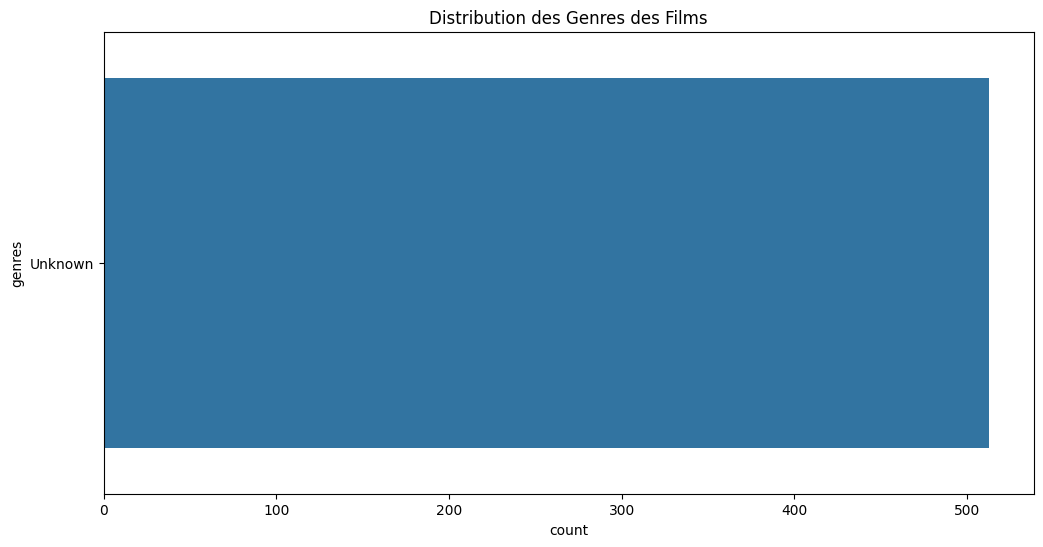

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exemple : Distribution des genres
plt.figure(figsize=(12, 6))
sns.countplot(y='genres', data=data_cleaned, order=data_cleaned['genres'].value_counts().index)
plt.title("Distribution des Genres des Films")
plt.show()


 Exportation et Simulation Cloud

In [ ]:
# Exporter le fichier nettoyé pour le cloud
data_cleaned.to_csv('cleaned_disney_movies.csv', index=False)
print("\nFichier nettoyé exporté avec succès.")



Fichier nettoyé exporté avec succès.


In [ ]:
pip install pcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
import pcloud

# Remplacez 'your_access_token' par votre jeton d'API pCloud
token = 'dghdghdj'
client = pcloud.Api(token=token)

# Vérification de la connexion
if client.check_token():
    print("Connexion établie avec succès !")

# Liste des fichiers dans le répertoire racine
files = client.listfolder(path='/')
for file in files['metadata']['contents']:
    print(file['name'])


AttributeError: module 'pcloud' has no attribute 'Api'